In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.insert(0,'/home/bradhakrishnan/ECE276A_PR1/code/')

In [8]:
import load_data
import os
# load_data.read_data()
data_base_path= "/home/bradhakrishnan/ECE276A_PR1/data/"
 

# CALIBRATION Tasks 

1. Figure out how long the setup is static to measure the bias.
2. Once bias computed use the Value formula to find the values.
3. DONT FORGET TO CONVERT THE UNITS.

In [9]:
import jax
import jax.numpy as jnp
import numpy as np
imud, vicd, camd=load_data.load_dataset(1)
# vicd_data = jnp.array(vicd['rots'])
# vicd_ts = jnp.array(vicd['ts'], dtype=np.float64)
vicd_data=vicd['rots']
vicd_ts=vicd['ts']
imu_data= imud
jax.config.update("jax_enable_x64", True)


Data import took: 0.013691186904907227 sec.



In [10]:
def if_rotation_identity(rotation, threshold=0.001, debug=False):
    diagonal = jnp.diag(rotation)
    if debug:
        print(jnp.abs(diagonal - 1.0))
    is_diagonal_close_to_one = jnp.all(jnp.abs(diagonal - 1.0) < threshold)
    if debug:
        print(is_diagonal_close_to_one)
    return is_diagonal_close_to_one

def find_stationary_end(vicd_data, threshold=0.001, debug=False):
    idx=0
    while(if_rotation_identity(vicd_data[:,:, idx], threshold, debug=debug)):
        idx+=1
    if debug:
        print(idx)
    return idx


def get_static_data(vicd_data, vicd_ts, imu_data, indentity_check_threshold=0.001, debug=False):
    stationary_end_idx= find_stationary_end(vicd_data, threshold=indentity_check_threshold, debug=debug)
    print("Number of Static entries:: ", stationary_end_idx)
    stationary_start_time= vicd_ts[:,0][0]  
    stationary_end_time= vicd_ts[:,stationary_end_idx][0]
    static_imu_data=imu_data[:,0:stationary_end_idx]
    # if stationary_start_time== static_imu_data[0, 0] and stationary_end_time==static_imu_data[0,stationary_end_idx-1]:
    #     print(f"We might have to match the timestamps :: \nVidcon start:: {stationary_start_time} \nIMU start:: {static_imu_data[0, 0]}" )
    #     print(f"\n\nVidcon end:: {stationary_end_time} \nIMU end:: {static_imu_data[0, stationary_end_idx-1]}" )
    #     print(stationary_start_time-static_imu_data[0, 0])
    #     print(stationary_end_time-static_imu_data[0, stationary_end_idx-1])
    return static_imu_data

In [11]:
def find_bias():
    all_static_data= None
    for ii in range(1,10):
        print(f"Dataset {ii} :: \n")
        imud, vicd, camd=load_data.load_dataset(ii)
        vicd_data = vicd['rots']
        vicd_ts = vicd['ts']
        imu_data= imud
        static_imu_data= get_static_data(vicd_data, vicd_ts, imu_data, indentity_check_threshold=0.01, debug=False)
        if all_static_data is None:
            all_static_data=static_imu_data
        else:
            all_static_data= np.concatenate((all_static_data, static_imu_data), axis=1)
    
    bias= np.mean(all_static_data[1:, :], axis=1)
    # we need to manually compute the bias for 
    print(f"Bias ::",bias)
    return bias


In [13]:
bias= find_bias()

Dataset 1 :: 

Data import took: 0.005824565887451172 sec.

Number of Static entries::  1082
Dataset 2 :: 

Data import took: 0.005640268325805664 sec.

Number of Static entries::  902
Dataset 3 :: 

Data import took: 0.003502368927001953 sec.

Number of Static entries::  618
Dataset 4 :: 

Data import took: 0.0030493736267089844 sec.

Number of Static entries::  697
Dataset 5 :: 

Data import took: 0.003154754638671875 sec.

Number of Static entries::  503
Dataset 6 :: 

Data import took: 0.0031037330627441406 sec.

Number of Static entries::  430
Dataset 7 :: 

Data import took: 0.003420591354370117 sec.

Number of Static entries::  495
Dataset 8 :: 

Data import took: 0.003409147262573242 sec.

Number of Static entries::  748
Dataset 9 :: 

Data import took: 0.003221273422241211 sec.

Number of Static entries::  637
Bias :: [-511.0872055  -500.94437173  606.54433901  374.07738874  375.6809555
  370.13007199]


In [32]:
# in the bias list the value we get z axis linear acceleration is basically the measurement for 9.8 m/s( i.e; g) acceleration
# so we can mathematically compute the bias using the avg(IMU measurement for 1g)-(1/scale_factor)

# acc_z_bias= bias[2]- (1/((accl_vref/1023)/accl_sensitivity_all_axis))
# bias= bias.at[2].set(acc_z_bias)
# acc_x= (all_static_data[1,:]- bias[0]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
# acc_y= (all_static_data[2,:]- bias[1]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
# acc_z= (all_static_data[3,:]- bias[2]) * ((accl_vref/1023)/accl_sensitivity_all_axis)

# w_x= (all_static_data[4,:]- bias[3]) * ((roll_vref/1023)/roll_sensitivity)
# w_y= (all_static_data[5,:]- bias[4]) * ((pitch_vref/1023)/pitch_sensitivity)
# w_z= (all_static_data[6,:]- bias[5]) * ((yaw_vref/1023)/yaw_sensitivity)

(514.0, Array(142.79596, dtype=float32))

In [25]:
def get_calibrated_IMU_data(bias):
    ## SENSITIVITY 
    accl_sensitivity_all_axis=300 #mV/g
    yaw_sensitivity = 3.33*(180/jnp.pi) #mV/ °/s
    roll_sensitivity = 3.33*(180/jnp.pi)
    pitch_sensitivity = 3.33*(180/jnp.pi)
    
    ## REFERENCE VOLTAGES
    accl_vref= 3.3*1000
    yaw_vref= 3.3*1000 #z axis
    roll_vref=3.3*1000 # x axis
    pitch_vref=3.3*1000 # y axis
    
    for ii in range(1,10):
        print(f"Dataset {ii} :: \n")
        imud, vicd, camd=load_data.load_dataset(ii)
        # vicd_data = jnp.array(vicd['rots'])
        # vicd_ts = jnp.array(vicd['ts'])
        # imu_data= jnp.array(imud)
        
        vicd_data = vicd['rots']
        vicd_ts = vicd['ts']
        imu_data= imud
        
        # in the bias list the value we get z axis linear acceleration is basically the measurement for 9.8 m/s( i.e; g) acceleration
        # so we can mathematically compute the bias using the avg(IMU measurement for 1g)-(1/scale_factor)
        acc_z_bias= bias[2]- 1/((accl_vref/1023)/accl_sensitivity_all_axis)
        # bias= bias.at[2].set(acc_z_bias)
        bias[2]=acc_z_bias

        
        
        acc_x= (imu_data[1,:]- bias[0]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
        acc_y= (imu_data[2,:]- bias[1]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
        acc_z= (imu_data[3,:]- bias[2]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
        
        w_x= (imu_data[4,:]- bias[3]) * ((roll_vref/1023)/roll_sensitivity)
        w_y= (imu_data[5,:]- bias[4]) * ((pitch_vref/1023)/pitch_sensitivity)
        w_z= (imu_data[6,:]- bias[5]) * ((yaw_vref/1023)/yaw_sensitivity)
    
        # Preserve the 0th row from imu_data
        calibrated_imu = np.zeros_like(imu_data)
        
        # # Set the 0th row
        # calibrated_imu = calibrated_imu.at[0, :].set(imu_data[0, :])
        
        # # Set the computed acceleration and angular velocity values
        # calibrated_imu = calibrated_imu.at[1, :].set(acc_x)
        # calibrated_imu = calibrated_imu.at[2, :].set(acc_y)
        # calibrated_imu = calibrated_imu.at[3, :].set(acc_z)
        # calibrated_imu = calibrated_imu.at[4, :].set(w_x)
        # calibrated_imu = calibrated_imu.at[5, :].set(w_y)
        # calibrated_imu = calibrated_imu.at[6, :].set(w_z)
    
        # Set the 0th row
        calibrated_imu[0, :] = imu_data[0, :]
        
        # Set the computed acceleration and angular velocity values
        calibrated_imu[1, :] = acc_x
        calibrated_imu[2, :] = acc_y
        calibrated_imu[3, :] = acc_z
        calibrated_imu[4, :] = w_x
        calibrated_imu[5, :] = w_y
        calibrated_imu[6, :] = w_z
        break
    return calibrated_imu


def calibrate_v2(bias):
    ## SENSITIVITY 
    accl_sensitivity_all_axis=300 #mV/g
    yaw_sensitivity = 3.33*(180/jnp.pi) #mV/ °/s
    roll_sensitivity = 3.33*(180/jnp.pi)
    pitch_sensitivity = 3.33*(180/jnp.pi)
    
    ## REFERENCE VOLTAGES
    accl_vref= 3.3*1000
    yaw_vref= 3.3*1000 #z axis
    roll_vref=3.3*1000 # x axis
    pitch_vref=3.3*1000 # y axis
    
    for ii in range(1,10):
        print(f"Dataset {ii} :: \n")
        imud, vicd, camd=load_data.load_dataset(ii)
        # vicd_data = jnp.array(vicd['rots'])
        # vicd_ts = jnp.array(vicd['ts'])
        # imu_data= jnp.array(imud)
        
        vicd_data = vicd['rots']
        vicd_ts = vicd['ts']
        imu_data= imud
    
        
        # in the bias list the value we get z axis linear acceleration is basically the measurement for 9.8 m/s( i.e; g) acceleration
        # so we can mathematically compute the bias using the avg(IMU measurement for 1g)-(1/scale_factor)
        acc_z_bias= bias[2]- 1/((accl_vref/1023)/accl_sensitivity_all_axis)
        # bias= bias.at[2].set(acc_z_bias)
        bias[2]=acc_z_bias
        # Compute scaling factors
        accl_factor = (accl_vref / 1023) / accl_sensitivity_all_axis
        gyro_factors = np.array([
            (roll_vref / 1023) / roll_sensitivity,
            (pitch_vref / 1023) / pitch_sensitivity,
            (yaw_vref / 1023) / yaw_sensitivity
        ])
        
        # Calibrate acceleration and angular velocity using vectorized operations
        calibrated_imu = np.zeros_like(imu_data)
        calibrated_imu[0, :] = imu_data[0, :]  # Preserve the 0th row
        
        # Apply bias correction and scaling in one step
        calibrated_imu[1:4, :] = (imu_data[1:4, :] - bias[:3, np.newaxis]) * accl_factor
        calibrated_imu[4:7, :] = (imu_data[4:7, :] - bias[3:, np.newaxis]) * gyro_factors[:, np.newaxis]
        break
    return calibrated_imu

In [26]:
# calibrated_imu=get_calibrated_IMU_data(bias)
calibrated_imu=calibrate_v2(bias)


Dataset 1 :: 

Data import took: 0.005307674407958984 sec.



# ORIENTATION Tracking

MOTION model => qt+1 = f(qt, τtωt) := qt ◦ exp([0, τtωt/2])

OBSERVATION model => [0, at] = h(qt) := (qt^-1) ◦ [0, 0, 0, −g] ◦ qt]

1. The starting point is q0 = [1, 0, 0, 0],
2. Find qt+1 = f(qt, τtωt) := qt ◦ exp([0, τtωt/2])

In [16]:
q0 =jnp.array([1, 0, 0, 0])
calibrated_imu.shape[1]
q0.shape


(4,)

In [22]:
import transforms3d as t3d
from tqdm import tqdm
prev_q=jnp.asarray(q0)
pred_qts= jnp.asarray([prev_q])
for sample_idx in range(0,calibrated_imu.shape[1]-1):
    del_t= (imu_data[0,sample_idx+1]- imu_data[0,sample_idx])*0.5
    w_vec=jnp.array(calibrated_imu[4:,sample_idx])
    exp_term = jnp.concatenate((jnp.array([0]), w_vec*del_t), axis=0)
    curr_q= t3d.quaternions.qmult(prev_q,t3d.quaternions.qexp(exp_term))
    pred_qts.append(jnp.asarray(curr_q/jnp.linalg.norm(curr_q)))
    prev_q=curr_q
    # h(qt) compute
    curr_q_inv= t3d.quaternions.qinverse(curr_q) 
    temp=t3d.quaternions.qmult(curr_q_inv, jnp.array([0,0,0,-1]))
    h_qt=t3d.quaternions.qmult(temp, curr_q)
    
pred_qts = jnp.column_stack(pred_qts)


In [45]:
pred_qts= jnp.asarray([prev_q])


In [49]:
jnp.diff(imu_data[0, :]).mean()


Array(0.0100049, dtype=float64)

In [77]:
pred_qts[:,0]

Array([1., 0., 0., 0.], dtype=float64)

In [27]:
import transforms3d as t3d
from tqdm import tqdm
prev_q=jnp.asarray(q0)
pred_qts= [prev_q]
for sample_idx in range(0,calibrated_imu.shape[1]):
    del_t= (imu_data[0,sample_idx]- imu_data[0,sample_idx-1])*0.5 if sample_idx else 0.0100049*0.5
    w_vec=jnp.array(calibrated_imu[4:,sample_idx])
    exp_term = jnp.concatenate((jnp.array([0]), w_vec*del_t), axis=0)

    curr_q= t3d.quaternions.qmult(pred_qts[sample_idx],t3d.quaternions.qexp(exp_term))
    pred_qts.append(curr_q)
        
pred_qts= jnp.column_stack(pred_qts)

# random_shit

In [32]:
gt_roll=[0]* vicd_data.shape[-1]
gt_pitch=[0]* vicd_data.shape[-1]
gt_yaw=[0]* vicd_data.shape[-1]
pred_roll=[0]* imu_data.shape[-1]
pred_pitch=[0]* imu_data.shape[-1] 
pred_yaw =[0]* imu_data.shape[-1]


for idx in range(vicd_data.shape[-1]):    
    gt_roll[idx] , gt_pitch[idx] , gt_yaw[idx] =t3d.euler.mat2euler(vicd_data[:,:, idx], 'sxyz')
    pred_roll[idx], pred_pitch[idx], pred_yaw[idx] = t3d.euler.mat2euler(t3d.quaternions.quat2mat(a[:,idx]), 'sxyz')

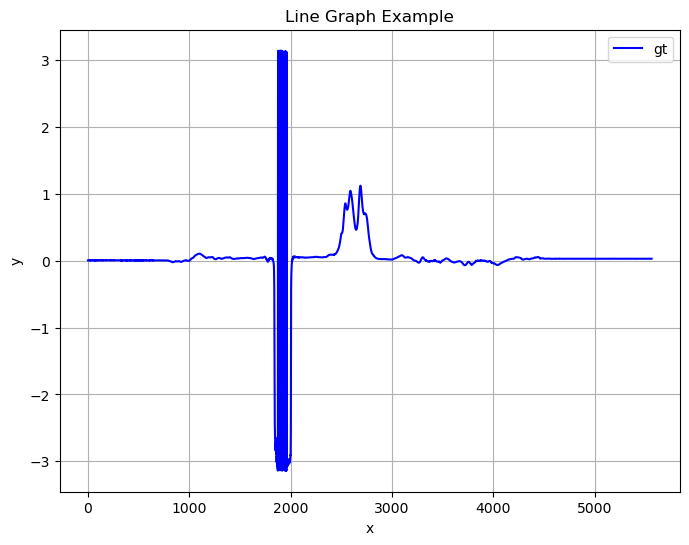

In [38]:
import matplotlib.pyplot as plt
# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot a line graph
plt.plot(gt_yaw, label='gt', color='blue')
# plt.plot(pred_pitch, label='pred', color='red')

# Adding title and labels
plt.title('Line Graph Example')
plt.xlabel('x')
plt.ylabel('y')

# Adding a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Time Sync

In [34]:
import numpy as np

def find_closest_older_vidcon(imu_timestamps, vidcon_timestamps):
    indices = np.searchsorted(vidcon_timestamps, imu_timestamps, side='right') - 1
    indices = np.clip(indices, 0, len(vidcon_timestamps) - 1)  # Ensure index is valid
    return vidcon_timestamps[indices], indices

imu_timestamps = calibrated_imu[0,:]  # IMU time series
vidcon_timestamps =  vicd_ts[0] # Vidcon time series

closest_vidcon, closest_idxs = find_closest_older_vidcon(imu_timestamps, vidcon_timestamps)

synced_vicd_data = vicd_data[:, :, closest_idxs]
vicd_quaternions = np.array([t3d.quaternions.mat2quat(synced_vicd_data[:, :, i]) for i in range(synced_vicd_data.shape[2])]).T


# Grad Descent

## WTF Is cost func

In [30]:
pred_qts[:, :-1].shape
pred_qts[:,1:].

Array([[ 1.00000000e+00,  9.99999988e-01,  9.99999987e-01, ...,
         9.88128804e-01,  9.88110787e-01,  9.88109838e-01],
       [-6.41843540e-06, -1.00267361e-04, -1.06531568e-04, ...,
        -1.47562109e-01, -1.47654290e-01, -1.47656351e-01],
       [ 2.64607802e-05,  5.42517315e-05, -8.10434541e-07, ...,
        -4.10223545e-02, -4.10966000e-02, -4.10848373e-02],
       [-1.07878565e-05, -1.09221179e-04, -1.19732889e-04, ...,
        -1.20024135e-02, -1.20976457e-02, -1.21895638e-02]],      dtype=float64)

In [ ]:
    
jnp.concatenate((jnp.array([0]), w_vec*del_t), axis=0)

In [28]:
import quaternion_ops as qops

def compute_rot_error(qt_1, qt):
    return  4 * ((jnp.linalg.norm(qops.qlog(qops.qmult(qops.qinverse(qt_1), qt))))**2)

def compute_pos_error(qt, acc_vec):
    h_qt=qops.qmult(qops.qmult(qops.qinverse(qt) , jnp.array([0,0,0,1])), qt)
    return jnp.linalg.norm(jnp.concatenate((jnp.array([0]), acc_vec), axis=0)-h_qt)**2


rot_error_vec = jax.vmap(compute_rot_error, in_axes=(1, 1))
pos_error_vec= jax.vmap(compute_pos_error, in_axes=(1,1))

def cost(pred_qts,calibrated_imu, rot_error_vec = jax.vmap(compute_rot_error, in_axes=(1, 1)),
pos_error_vec= jax.vmap(compute_pos_error, in_axes=(1))):
    
    cost_op=(rot_error_vec(pred_qts[:, :-1], pred_qts[:, 1:]).sum()+pos_error_vec(pred_qts[:, 1:],jnp.array(calibrated_imu[1:4,:])).sum())*0.5
    return cost_op



In [29]:
def check_threshold(pred_qts, new_qts, threshold=1e-6, percentage=0.8):
    diff = jnp.linalg.norm(pred_qts - new_qts, axis=0)  # Compute difference for each element
    below_threshold = diff < threshold  # Boolean mask where difference is below threshold
    ratio = jnp.mean(below_threshold)  # Compute the fraction of elements below the threshold
    return ratio >= percentage  # Return True if at least 80% of elements meet the condition


In [30]:
from tqdm import tqdm
def compute_new_preds(q, grad):
    new_q= q-(grad)
    return new_q/ jnp.linalg.norm(new_q)
    
    
def projected_grad_descent(pred_qts,calibrated_imu, step_size=1, epochs=2, stopping_criteria=0.001):
    new_pred_vec=jax.vmap(compute_new_preds)
    initial_step=step_size
    decay_rate=0.01
    for epoch in tqdm(range(epochs)):
        grad=jax.jacrev(cost)(pred_qts,calibrated_imu) *step_size
        new_qts=new_pred_vec(pred_qts, grad, )
        # if check_threshold(pred_qts, new_qts):
        #     print("Stopped at epoch:: ", epoch)
        #     return new_qts
        pred_qts= new_qts
        step_size = initial_step / (1 + decay_rate * epoch)
       
    return pred_qts


In [31]:
a=projected_grad_descent(pred_qts,calibrated_imu,step_size=0.01, epochs=1000, stopping_criteria=0.001)

100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


In [21]:
a.device_buffer.device()

Array([[ 6.89870807e-02,  3.06061001e-07,  2.64652006e-07, ...,
         1.92589918e-02,  1.92483069e-02,  1.92489973e-02],
       [ 7.18617580e-03, -5.17895727e-10,  3.06963274e-09, ...,
        -2.28801665e-02, -2.29061947e-02, -2.28681294e-02],
       [-1.17235097e-01, -4.56389808e-09, -5.99592431e-08, ...,
        -1.78023177e-02, -1.77654049e-02, -1.78151504e-02],
       [ 3.94659707e-02,  1.15527198e-08,  2.73085952e-08, ...,
        -8.56738497e-03, -8.56467000e-03, -8.59433213e-03]],      dtype=float64)